<h1>Exploratory Data Analysis of Environmental Noise for K2-Ingeniería</h1>

In [1]:
import pandas as pd
import numpy as np
import glob 
import datetime
# import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import branca
import geopandas
import folium
pd.options.display.float_format = '{:,.2f}'.format
import json
from geopy import distance

In [2]:
df1 = pd.read_csv(r'../data/SDA_data.csv', dtype='unicode', encoding='utf_8')

In [3]:
df = df1.sample(frac=0.5, replace=True, random_state=1)
df.shape

(22687035, 9)

<h3>Data Wrangling & Cleaning</h3>

In [4]:
# # Name correction
df.columns = ['Estación', 'Serial', 'Variable', 'Fecha','Valor', 'Ponderación', 'Tipo', 'Unidad', 'Componente']
df = df[['Estación', 'Serial', 'Variable', 'Fecha','Valor', 'Ponderación', 'Tipo']]

In [5]:
df['Valor'] = df['Valor'].astype('float')

In [6]:
# 1. Remove special character when loading the source file
df['Estación'] = df['Estación'].str.replace('�','')
df['Estación'] = df['Estación'].str.replace('"','')
# due to problems with enconding, some additional relacement needs to occur:
df['Estación'] = df['Estación'].str.replace(u'\ufeff','')

In [7]:
df.head()
# !pip install openpyxl

,Estación,Serial,Variable,Fecha,Valor,Ponderación,Tipo
6762380,CAI Venecia,11354,L90,2020-08-05 04:00:00,56.00,Lin,1/3 Oct 40Hz
491263,Restrepo,11345,L90,2020-02-09 06:00:58,29.10,Lin,1/3 Oct 4kHz
13419401,CAI Venecia,11354,L10,2019-09-05 14:00:00,22.20,Lin,1/3 Oct 20kHz
23440075,Santa Cecilia,11371,L10,2019-08-03 23:00:00,50.00,Lin,1/3 Oct 20Hz
26331983,CAI San Victorino,11369,L50,2019-12-18 15:00:31,70.50,Lin,1/3 Oct 50Hz


<h4>Add year, day of the week, and time information</h4>

In [8]:
df['Fecha'] = pd.to_datetime(df['Fecha'])
df["Year"] = df.Fecha.dt.year
df['Mes'] =  df['Fecha'].dt.to_period('M')
df["Semana"] = df.Fecha.dt.isocalendar().week
df['Hora'] = pd.to_datetime(df['Fecha']).dt.hour
df['Fecha_Dia'] =  df['Fecha'].dt.to_period('D')
df["Dia"]= df.Fecha.dt.day_name()
df['Dia'] = pd.Categorical(df['Dia'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],ordered=True)


In [9]:
df['Fecha'] = pd.to_datetime(df['Fecha'])
start_date = '2019-05-01 00:00'
end_date = '2020-08-01 00:00'
df = df[(df['Fecha']> start_date) & (df['Fecha'] <= end_date)]
df.head()

,Estación,Serial,Variable,Fecha,Valor,Ponderación,Tipo,Year,Mes,Semana,Hora,Fecha_Dia,Dia
491263,Restrepo,11345,L90,2020-02-09 06:00:58,29.10,Lin,1/3 Oct 4kHz,2020,2020-02,6,6,2020-02-09,Sunday
13419401,CAI Venecia,11354,L10,2019-09-05 14:00:00,22.20,Lin,1/3 Oct 20kHz,2019,2019-09,36,14,2019-09-05,Thursday
23440075,Santa Cecilia,11371,L10,2019-08-03 23:00:00,50.00,Lin,1/3 Oct 20Hz,2019,2019-08,31,23,2019-08-03,Saturday
26331983,CAI San Victorino,11369,L50,2019-12-18 15:00:31,70.50,Lin,1/3 Oct 50Hz,2019,2019-12,51,15,2019-12-18,Wednesday
7361472,Restrepo,11345,Lmax,2020-03-29 02:01:03,61.70,Lin,1/3 Oct 125Hz,2020,2020-03,13,2,2020-03-29,Sunday


<h4>Add latitude and longitude</h4>

In [10]:
# latitude and longitude data
df_locations_sda = pd.read_csv("../data/otros/Localizaciones.csv", sep  =';')

# rename column for merge
df_locations_sda.rename(columns={'Estación':'name_station_old','sin_comillas':'Estación'}, inplace=True)

# Add latitude and longitude data
df_sda = df.merge(df_locations_sda[['Estación','latitude','longitude']],how ="left", left_on="Estación",right_on ="Estación")


In [11]:
# check stations that do not cross
print(len(df_sda['Estación'].unique()))
df_sda[df_sda['latitude'].isnull()]['Estación'].unique()

29


array([], dtype=object)

In [12]:
df_sda.head()

,Estación,Serial,Variable,Fecha,Valor,Ponderación,Tipo,Year,Mes,Semana,Hora,Fecha_Dia,Dia,latitude,longitude
0,Restrepo,11345,L90,2020-02-09 06:00:58,29.10,Lin,1/3 Oct 4kHz,2020,2020-02,6,6,2020-02-09,Sunday,4.59,-74.10
1,CAI Venecia,11354,L10,2019-09-05 14:00:00,22.20,Lin,1/3 Oct 20kHz,2019,2019-09,36,14,2019-09-05,Thursday,4.59,-74.14
2,Santa Cecilia,11371,L10,2019-08-03 23:00:00,50.00,Lin,1/3 Oct 20Hz,2019,2019-08,31,23,2019-08-03,Saturday,4.74,-74.02
3,CAI San Victorino,11369,L50,2019-12-18 15:00:31,70.50,Lin,1/3 Oct 50Hz,2019,2019-12,51,15,2019-12-18,Wednesday,4.60,-74.08
4,Restrepo,11345,Lmax,2020-03-29 02:01:03,61.70,Lin,1/3 Oct 125Hz,2020,2020-03,13,2,2020-03-29,Sunday,4.59,-74.10


<h3>heat map by station and hour</h3>

In [13]:
# Average value per hour according to season and variable
df_group  = df_sda.groupby(['Estación','latitude','longitude','Variable','Hora'])[['Valor']].mean().reset_index()

# clean data
df_group = df_group.dropna(axis=0, subset=['latitude','longitude', 'Valor'])
df_group['latitude'] = df_group['latitude'].astype(float)
df_group['longitude'] = df_group['longitude'].astype(float)
df_group['scaled_weight'] = df_group["Valor"] / df_group["Valor"].max()

df_test = df_group[df_group['Variable']=='Lmax']
hours = df_test['Hora'].unique()

In [14]:
df_test.sort_values(by="Valor",ascending =False).head()

,Estación,latitude,longitude,Variable,Hora,Valor,scaled_weight
3425,Fontibón,4.68,-74.14,Lmax,14,83.40,1.00
3427,Fontibón,4.68,-74.14,Lmax,16,83.14,1.00
3424,Fontibón,4.68,-74.14,Lmax,13,83.08,1.00
3422,Fontibón,4.68,-74.14,Lmax,11,82.98,1.00
1550,CAI Normandia,4.67,-74.11,Lmax,14,82.81,0.99


In [15]:
from folium import plugins

f = folium.Figure(width=900, height=400)

map_stations = folium.Map(location=[4.60971, -74.08175],
                    zoom_start = 11) .add_to(f)

# List comprehension to make out list of lists
heat_data = [[[row['latitude'],row['longitude'], row['scaled_weight']] for index, row in data.iterrows()] for data in [df_test[df_test['Hora'] == hour] for hour in hours]]

heat_data

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map_stations)
# # Display the map
map_stations

<h3>Sitios de Interés</h3>

In [16]:
df_sitiosinteres = geopandas.read_file("../data/otros/sitiosInteres.geojson", driver = "GeoJSON")

<h3> Merge SDA with extra data </h3>

<h4> External Data</h4>

In [22]:
df_radio = pd.read_csv("../data/otros/nuevas_variables.csv")

In [23]:
# Group SDA data
df_sda_var_hour_mean  = df_sda.groupby(['Estación','latitude','longitude','Variable','Hora'])[['Valor']].mean().reset_index()
df_sda_var_hour_mean.head()

,Estación,latitude,longitude,Variable,Hora,Valor
0,CAI 20 de Julio,4.57,-74.09,L10,0,49.35
1,CAI 20 de Julio,4.57,-74.09,L10,1,47.10
2,CAI 20 de Julio,4.57,-74.09,L10,2,46.47
3,CAI 20 de Julio,4.57,-74.09,L10,3,45.70
4,CAI 20 de Julio,4.57,-74.09,L10,4,50.01


In [34]:
# 
hours_group = [range(0,4),range(4,8),range(8,12),range(12,16),range(16,20),range(20,24)]

def plot_correlation(df, variable ):
        for hour_g in hours_group:
#             print(hour_g)
            df_test = df[df['Hora'].isin(list(hour_g))]

            # Merge SDA with extra data     
            df_merge = df_test.merge(df_radio[['Estación','conteo_bares_500m'
                                                ,'conteo_colegios_500m'
                                                ,'conteo_hoteles_500m'
                                                ,'conteo_ips_500m','AREA','CTNENCUEST','DENSIDAD','TVIVIENDA',
                                              'TP14_1_TIP','TP14_2_TIP']].set_index("Estación"), how ="left",left_on="Estación",right_on="Estación")


            # Plot Correlations
            plt.figure(figsize=(15,5))
            corr_mat  = df_merge.corr()
            sns.heatmap(corr_mat,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)
            plt.title("Plot Correlations {} hours({} - {})".format(variable,str(min(list(hour_g))),str(max(list(hour_g)))))

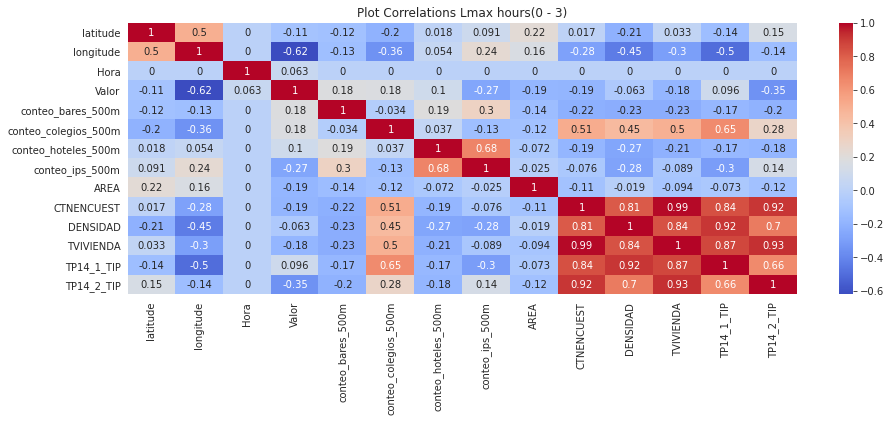

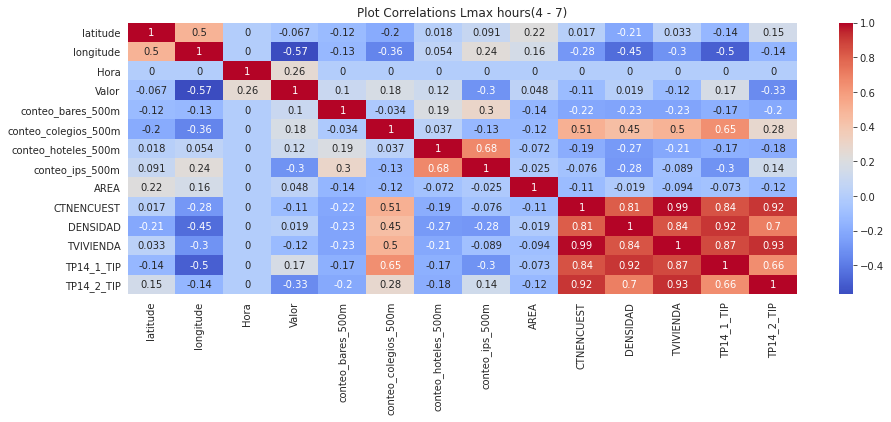

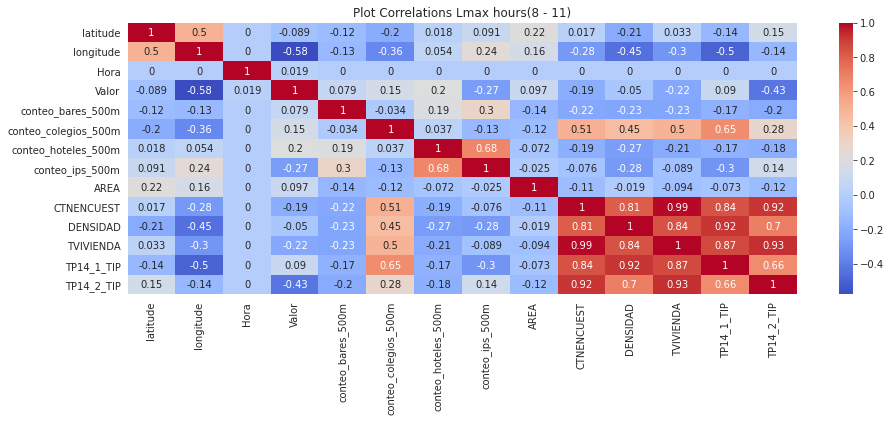

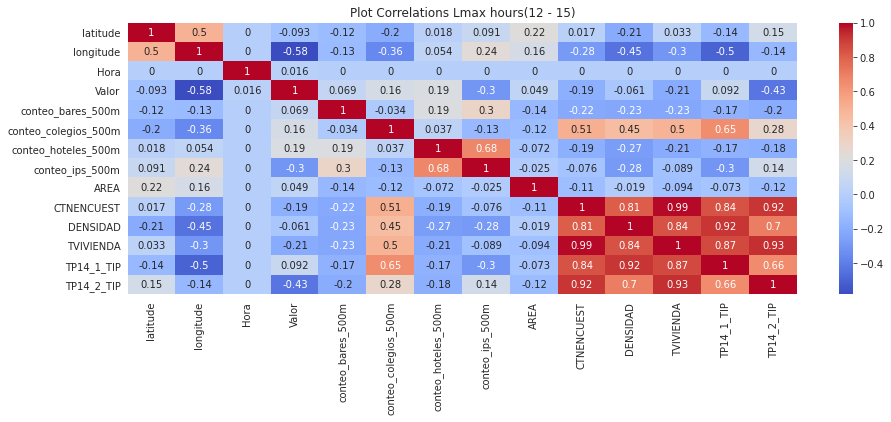

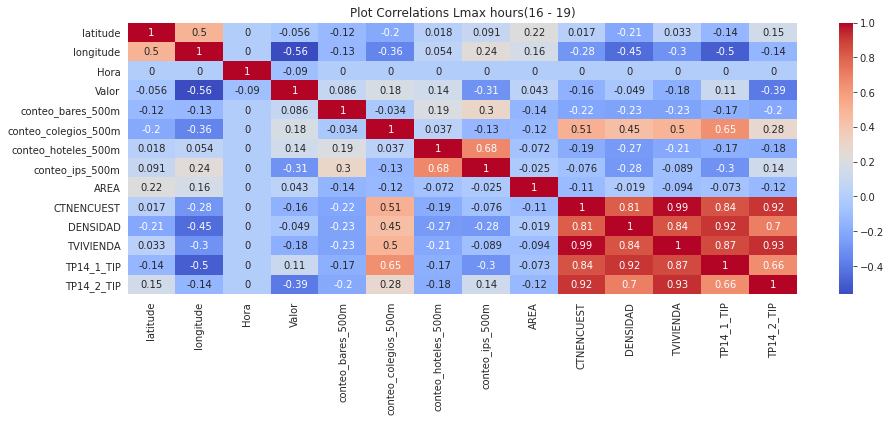

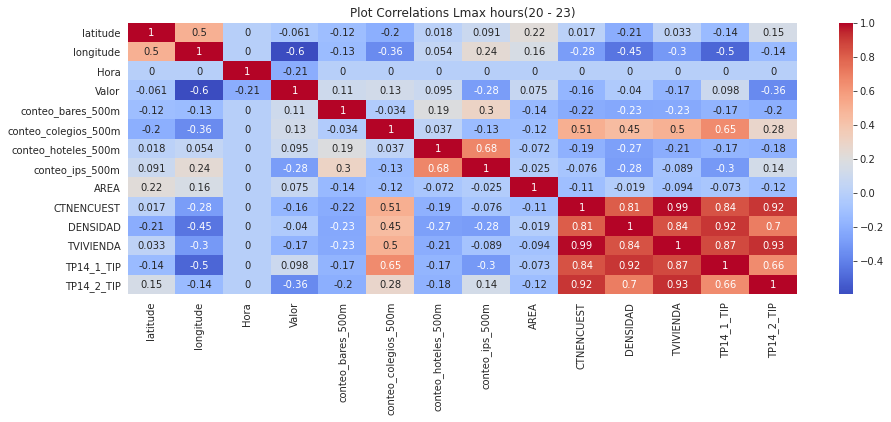

In [35]:
# %%capture
plot_correlation(df_sda_var_hour_mean[df_sda_var_hour_mean['Variable']=='Lmax'],"Lmax")

In [36]:
df_merge = df_sda_var_hour_mean.merge(df_radio[['Estación','conteo_bares_500m','conteo_bares_1km','conteo_bares_2km'
                                                ,'conteo_colegios_500m','conteo_colegios_1km','conteo_colegios_2km'
                                                ,'conteo_hoteles_500m','conteo_hoteles_1km','conteo_hoteles_2km','conteo_ips_500m'
                                                ,'conteo_ips_1km','conteo_ips_2km','AREA','CTNENCUEST','DENSIDAD','TVIVIENDA']].set_index("Estación"), how ="left",left_on="Estación",right_on="Estación")




In [155]:
df_sda_var_hour_mean.head()

,Estación,latitude,longitude,Variable,Hora,Valor
0,CAI 20 de Julio,4.57,-74.09,L10,0,48.86
1,CAI 20 de Julio,4.57,-74.09,L10,1,47.08
2,CAI 20 de Julio,4.57,-74.09,L10,2,46.38
3,CAI 20 de Julio,4.57,-74.09,L10,3,45.92
4,CAI 20 de Julio,4.57,-74.09,L10,4,49.81


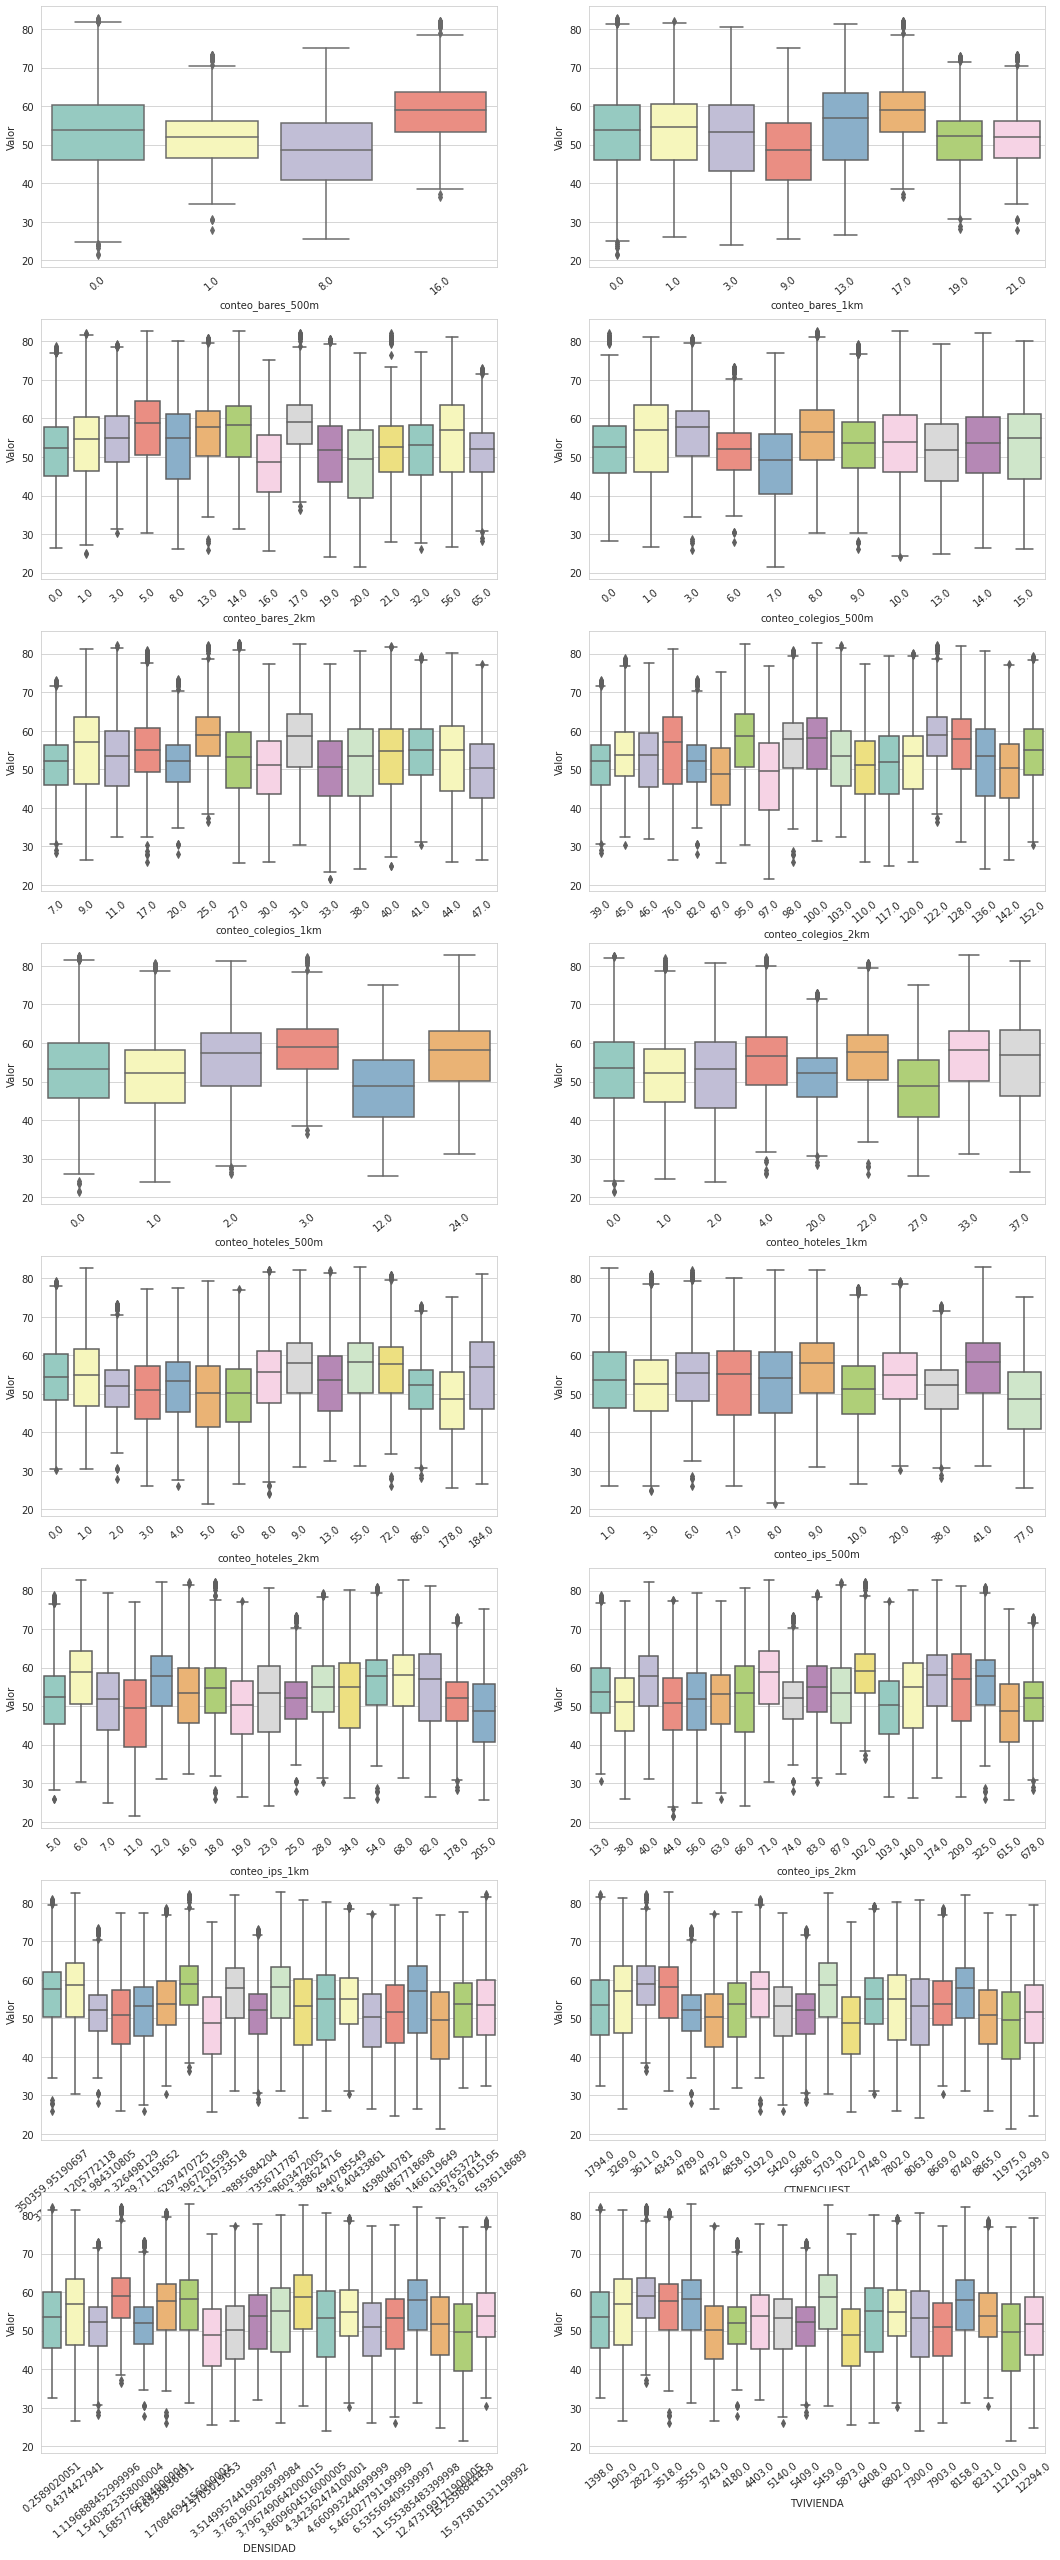

In [27]:
list_varstolook = ['conteo_bares_500m','conteo_bares_1km','conteo_bares_2km'
                                                ,'conteo_colegios_500m','conteo_colegios_1km','conteo_colegios_2km'
                                                ,'conteo_hoteles_500m','conteo_hoteles_1km','conteo_hoteles_2km','conteo_ips_500m'
                                                ,'conteo_ips_1km','conteo_ips_2km','AREA','CTNENCUEST','DENSIDAD','TVIVIENDA']


sns.set_style("whitegrid")

plt.figure(figsize=(18,45))
for i,var in enumerate(list_varstolook):
    plt.subplot(8,2,i+1)
    sns.boxplot(x =var, y ='Valor', data = df_merge, palette="Set3") 
    plt.xticks(rotation=40)


In [139]:
len(list_varstolook)

16